In [1]:
import mne 
from mne import create_info
from mne.io import RawArray

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, WeightedRandomSampler

In [2]:
mne.set_config('MNE_BROWSE_RAW_SIZE','10,5')  

In [3]:
# df = pd.read_csv("/Users/aarooshbalakrishnan/Desktop/P300/venv/AAROOSH_test18.csv")
df = pd.read_csv("/Users/rishabh/code/eeg/speakEEG/data/AAROOSH_test17INSANE.csv")

df.head()


,1-31,CP3,C3,F5,PO3,PO4,F6,C4,CP4,Marker
0,0.0,-55262.355469,-90680.992188,-265571.56250,5589.455566,-30005.603516,17863.914062,-68114.835938,-66681.187500,0
1,1.0,-55457.218750,-90052.890625,-263598.90625,5483.709473,-31734.958984,19545.189453,-68211.796875,-66671.335938,0
2,3.0,-55375.343750,-97257.570312,-271477.09375,5630.694336,-31934.246094,11362.105469,-74824.515625,-66632.375000,0
3,4.0,-55236.339844,-92025.179688,-267075.53125,5614.735352,-30082.917969,16352.355469,-69344.156250,-66672.609375,0
4,5.0,-55387.214844,-89319.304688,-263295.62500,5500.875488,-31133.205078,20022.890625,-67332.429688,-66676.367188,0


In [4]:
# def equalize_markers(df):
#     """
#     Each training file has markers in the last column. (Unique set = {0, 1, 2})
#     Remove surplus 1s such that 1s = 2s. We perform this action by replacing the 1s with 0s.
#     """
#     # Ensure the last column contains the markers
#     markers = df.iloc[:, -1]

#     # Find all 2s
#     marker_ix_2 = np.where(markers == 2)[0]
#     # Find all 1s
#     marker_ix_1 = np.where(markers == 1)[0]
#     np.random.shuffle(marker_ix_1)
#     # Indices of the 1s to remove
#     rem_ix = marker_ix_1[:len(marker_ix_1) - len(marker_ix_2)]

#     # Replace surplus 1s with 0s
#     markers.iloc[rem_ix] = 0
#     df.iloc[:, -1] = markers
    
#     return df


# # Example usage

# df = equalize_markers(df)




In [5]:
df = df.drop(df.columns[0], axis=1)
df.head()
df.columns = ["CP3", "C3", "F5", "PO3", "PO4", "F6", "C4", "CP4", "Marker"]
print(df['Marker'].unique())

[0 1 2]


Creating RawArray with float64 data, n_channels=9, n_times=146682
    Range : 0 ... 146681 =      0.000 ...   572.973 secs
Ready.
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/var/folders/jm/04n993nd2bsdf3z1z9k0621c0000gp/T/ipykernel_22476/1895213292.py:16: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


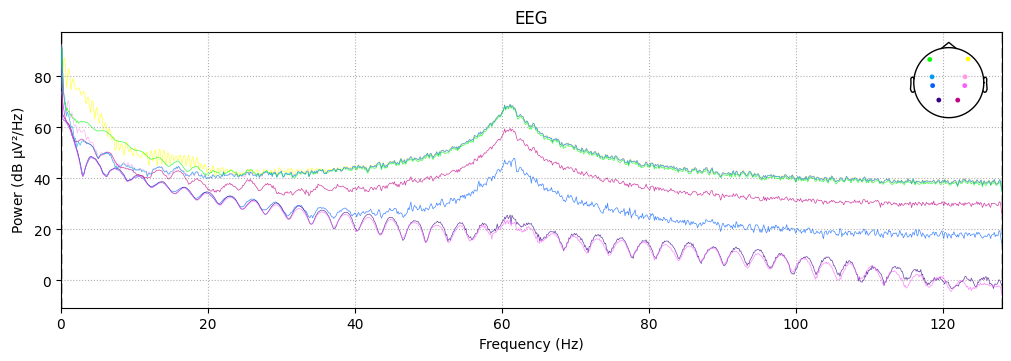

In [6]:
def df_to_raw(df):
    sfreq = 256  #our Neurosity headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T 
    df[:-1] *= 1e-6  #convert from uVolts to Volts 

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #plotting power spectral density
    raw.compute_psd().plot()

    return raw
raw = df_to_raw(df)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

/var/folders/jm/04n993nd2bsdf3z1z9k0621c0000gp/T/ipykernel_22476/4134320637.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


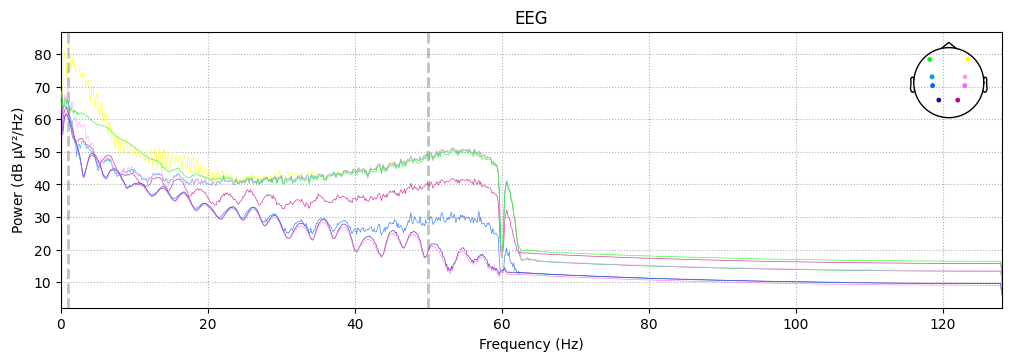

In [7]:
#wont be needed
raw.filter(1, 50)
raw.notch_filter(60)
raw.compute_psd().plot()

In [8]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [9]:
# event_id = {'Non-Target': 1, 'Target' : 2} #changed nontarget from 1 to 0

# eeg_channels = mne.pick_types(raw.info, eeg=True)
# picks= eeg_channels
# events = mne.find_events(raw)
# # Create epochs for each condition

# tmin = 0.3  # start of each epoch (200ms before the event)
# tmax = 0.5   # end of each epoch (500ms after the event)

# # Create epochs for each condition
# try:
#     epochs_condition1 = mne.Epochs(raw, events, event_id=event_id['Non-Target'], tmin=tmin, tmax=tmax, preload=True)
#     epochs_condition2 = mne.Epochs(raw, events, event_id=event_id['Target'], tmin=tmin, tmax=tmax, preload=True)
# except ValueError as e:
#     print(f"Error creating epochs: {e}")
#     # Additional debugging information
#     print(f"Events: {events}")
#     print(f"Event IDs: {event_id}")

# # Equalize the number of epochs across conditions
# epochs = [epochs_condition1, epochs_condition2]
# mne.epochs.equalize_epoch_counts(epochs, method='mintime')

# # Access the equalized epochs
# equalized_epochs_condition1, equalized_epochs_condition2 = epochs

# print(f"Number of epochs after equalization:")
# print(f"Condition 1: {len(equalized_epochs_condition1)}")
# print(f"Condition 2: {len(equalized_epochs_condition2)}")

#this one requires expertise to specify the right tmin, tmax
event_id = {'Non-Target': 1, 'Target' : 2}
tmin = -0.1
tmax = 0.6
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)


721 events found on stim channel Marker
Event IDs: [1 2]
sample drop %:  0.0


In [10]:
#mne.epochs.equalize_epoch_counts(epochs, method='mintime')

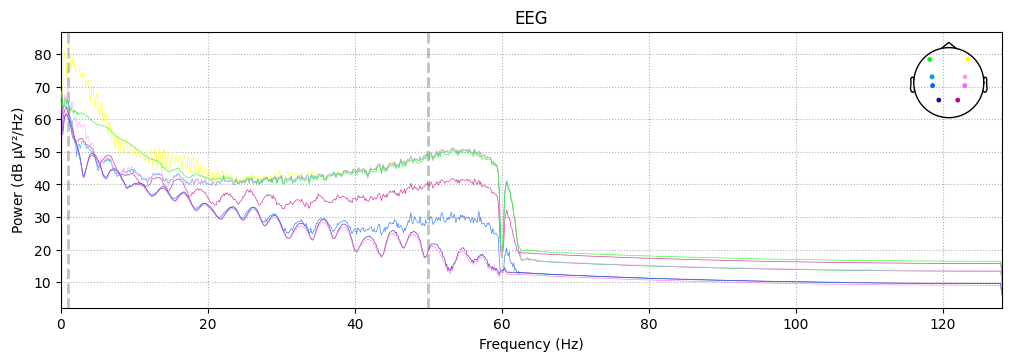

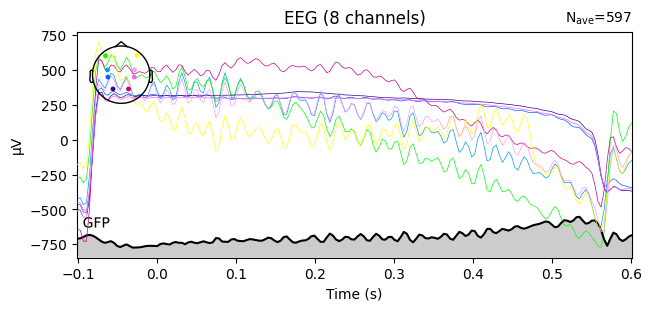

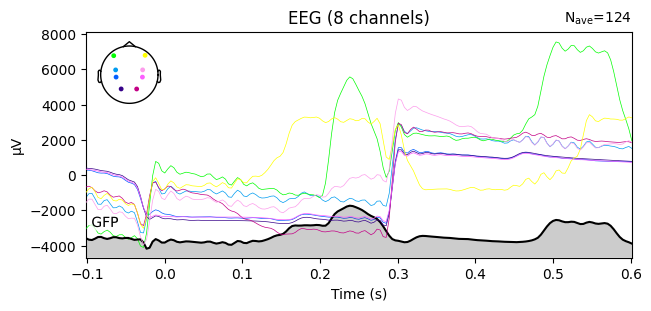

In [11]:
# evoked_non = equalized_epochs_condition1.average()
# evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')

# evoked_target = equalized_epochs_condition2.average()
# evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s');
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s');

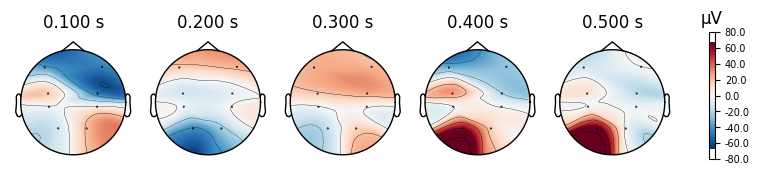

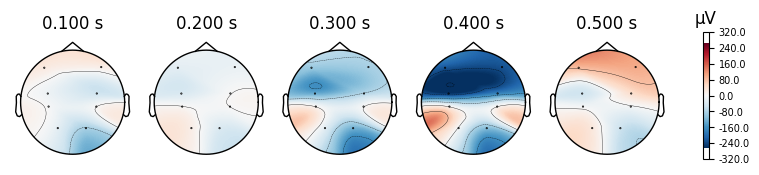

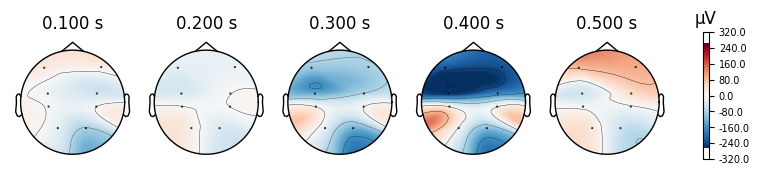

In [12]:
times = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times=times, colorbar=True)

No projector specified for this dataset. Please consider the method self.add_proj.


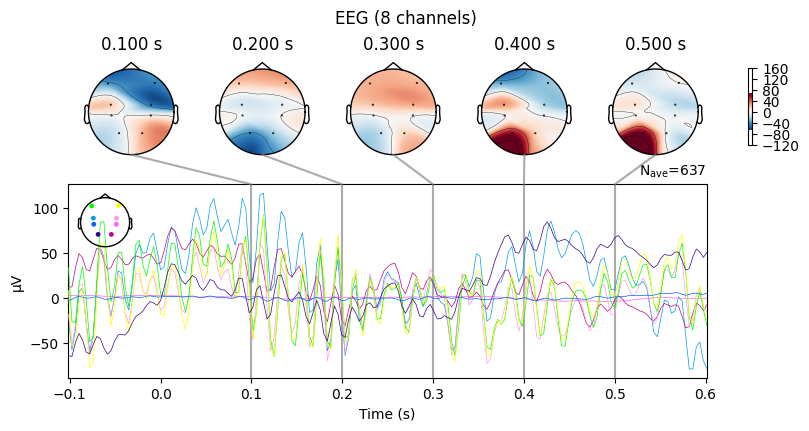

No projector specified for this dataset. Please consider the method self.add_proj.


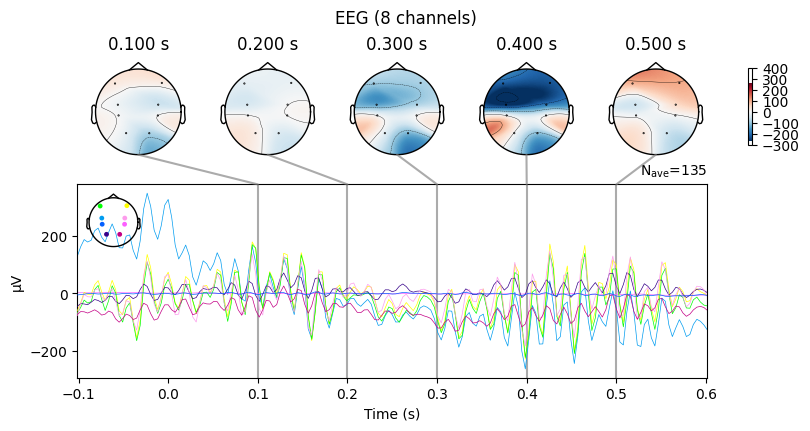

In [13]:
evoked_non.plot_joint(times=times);
evoked_target.plot_joint(times=times);

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


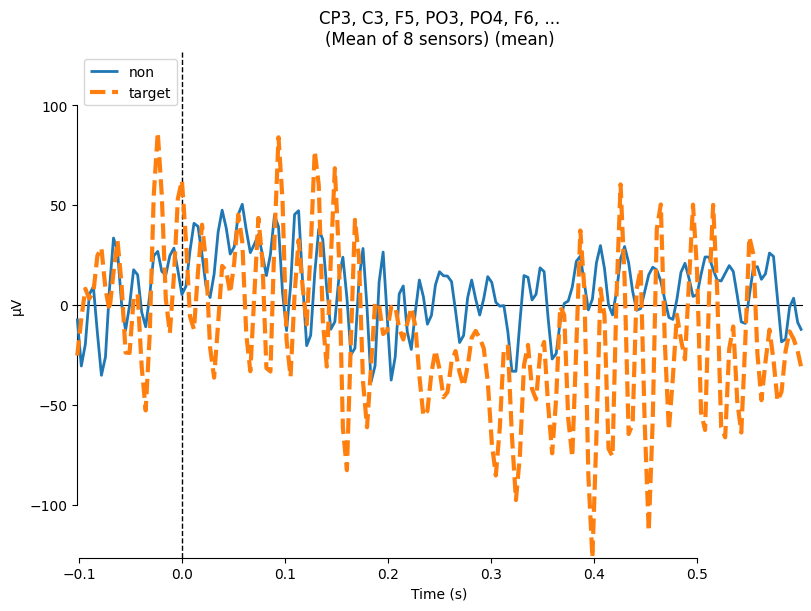

[<Figure size 800x600 with 1 Axes>]

In [14]:

def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}

mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine='mean',
                             colors=dict(non=0, target=1),
                             linestyles=dict(non='solid', target='dashed'),
                             styles=dict(non=dict(linewidth=2),target=dict(linewidth=3))) 

In [15]:
X = epochs.get_data()
y = epochs.events[:, -1]
number = y.shape[0]
print(X.shape)
print(y.shape)
print(type(X))
print(number)

# combined_epochs = mne.concatenate_epochs([equalized_epochs_condition1, equalized_epochs_condition2])

# # Extract the data and labels
# X = combined_epochs.get_data(picks=picks)
# y = combined_epochs.events[:, -1]

(772, 8, 181)
(772,)
<class 'numpy.ndarray'>
772


/var/folders/g6/svvfc77s77b53fd66g1kyjx00000gn/T/ipykernel_83817/2042620513.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


In [16]:
X[0].shape


(8, 181)

In [17]:
y[0]

1

In [18]:
train_size = number*7//10 #.7 times total amount
val_size = number*2//10 #.2 times total
test_size = number-(val_size+train_size) #.1 times total
#change above values
print(train_size+val_size+test_size)
X_train   = X[:train_size]
X_val     = X[train_size:val_size+train_size]
X_test    = X[-test_size:]

y_train   = y[:train_size]
y_val     = y[train_size:val_size+train_size]
y_test    = y[-test_size:]

772


In [19]:
X_train = np.transpose(X_train, (0, 2, 1))
X_val   = np.transpose(X_val, (0, 2, 1))
X_test  = np.transpose(X_test, (0, 2, 1))

In [20]:
X_train.shape, X_val.shape, X_test.shape

((540, 181, 8), (154, 181, 8), (78, 181, 8))

In [21]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

print("Training labels distribution:", np.unique(y_train, return_counts=True))
print("Validation labels distribution:", np.unique(y_val, return_counts=True))
print("Test labels distribution:", np.unique(y_test, return_counts=True))

Training data shape: (540, 181, 8) (540,)
Validation data shape: (154, 181, 8) (154,)
Test data shape: (78, 181, 8) (78,)
Training labels distribution: (array([1, 2]), array([443,  97]))
Validation labels distribution: (array([1, 2]), array([129,  25]))
Test labels distribution: (array([1, 2]), array([65, 13]))


In [22]:
for i in range(X_train.shape[2]):
    print(f"Feature {i} - Before scaling: Min = {X_train[:, :, i].min()}, Max = {X_train[:, :, i].max()}")

for i in range(X_train.shape[2]):
    print(f"Feature {i} - After scaling: Min = {X_train[:, :, i].min()}, Max = {X_train[:, :, i].max()}")


Feature 0 - Before scaling: Min = -0.0015325420337319894, Max = 0.0029919772880844606
Feature 1 - Before scaling: Min = -0.01683533488620647, Max = 0.036204528180692155
Feature 2 - Before scaling: Min = -0.01051708330105674, Max = 0.01971762570187406
Feature 3 - Before scaling: Min = -0.03482320880260008, Max = 0.04087663663896342
Feature 4 - Before scaling: Min = -0.030567743423750404, Max = 0.03501459835197357
Feature 5 - Before scaling: Min = -0.009568719379973271, Max = 0.018348567079350397
Feature 6 - Before scaling: Min = -0.007318711841198507, Max = 0.01368917003898944
Feature 7 - Before scaling: Min = -0.002733473695302531, Max = 0.0014220279249187642
Feature 0 - After scaling: Min = -0.0015325420337319894, Max = 0.0029919772880844606
Feature 1 - After scaling: Min = -0.01683533488620647, Max = 0.036204528180692155
Feature 2 - After scaling: Min = -0.01051708330105674, Max = 0.01971762570187406
Feature 3 - After scaling: Min = -0.03482320880260008, Max = 0.04087663663896342
Fea

In [23]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # Further split the temporary set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_val.shape[2]):
    X_val[:, :, i] = scalers[i].transform(X_val[:, :, i])     

for i in range(X_test.shape[2]):
    X_test[:, :, i] = scalers[i].transform(X_test[:, :, i]) 





NameError: name 'MinMaxScaler' is not defined

In [ ]:
print("Scaled X_train sample:")
print(X_train[:5, :, :])  # Print the first 5 samples

# Checking the distribution of the scaled values
for i in range(X_train.shape[2]):
    print(f"Feature {i} - Unique values after scaling: {np.unique(X_train[:, :, i])}")


Scaled X_train sample:
[[[-0.00286514 -0.0180551  -0.0270942  ... -0.02892718 -0.01433659
   -0.00490271]
  [-0.00211553  0.13393479  0.13595007 ...  0.1350165  -0.02593254
    0.00074039]
  [ 0.00255763  0.15816987  0.16725919 ...  0.16603683 -0.04074945
    0.01169832]
  ...
  [ 0.02856135 -0.03435616 -0.03980335 ... -0.03850052 -0.00309178
   -0.01778084]
  [ 0.02225038 -0.02363512 -0.02398343 ... -0.02218176  0.01359027
   -0.02838279]
  [ 0.01189434 -0.07659821 -0.07261189 ... -0.06925873  0.10708893
   -0.03435937]]

 [[-0.00679699 -0.13210066 -0.13278215 ... -0.13279938 -0.02245287
   -0.05094638]
  [ 0.00172309  0.00785302  0.01136017 ...  0.01121841 -0.03483865
   -0.04065203]
  [ 0.01078202  0.00962435  0.00554881 ...  0.00529424 -0.05163877
   -0.02889145]
  ...
  [ 0.01340966  0.01423701  0.01695287 ...  0.01608286  0.00303454
    0.03411384]
  [ 0.00599196  0.02134702  0.02942038 ...  0.02972075  0.02063408
    0.0278832 ]
  [-0.01327687 -0.03623229 -0.02415577 ... -0.0223

In [ ]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

-0.04046529614911073 -0.04455228457542949 -0.04084074902274863
-1.0 -3.4479510932080992 -3.1104173645968523
1.0000000000000004 1.6236033978666244 1.8085659989680816


In [ ]:
# scalers = []

# # Fit a scaler for each channel in the training set
# for i in range(X_train.shape[1]):
#     scaler = MinMaxScaler()
#     X_train[:, i, :] = scaler.fit_transform(X_train[:, i, :])
#     scalers.append(scaler)

# # Transform the validation and test sets using the fitted scalers
# for i in range(X_val.shape[1]):
#     X_val[:, i, :] = scalers[i].transform(X_val[:, i, :])

# for i in range(X_test.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])

In [ ]:
X_train = torch.FloatTensor(X_train)
X_val   = torch.FloatTensor(X_val)
X_test  = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train) - 1 #minus 1 so it becomes 0 or 1
y_val   = torch.LongTensor(y_val)   - 1 #minus 1 so it becomes 0 or 1
y_test  = torch.LongTensor(y_test)  - 1 #minus 1 so it becomes 0 or 1



In [ ]:
#dataset imbalance
print(len(y_train[y_train == 0]), len(y_train[y_train == 1]))
print(len(y_val[y_val == 0]),     len(y_val[y_val == 1]))
print(len(y_test[y_test == 0]),   len(y_test[y_test == 1]))

364 93
109 21
54 13


In [ ]:
labels_unique, counts = np.unique(y, return_counts=True)
labels_unique, counts

(array([1, 2]), array([527, 127]))

In [ ]:
#finds weights based on how many of each label there is
class_weights = [sum(counts) / c for c in counts]
class_weights

[1.2409867172675522, 5.149606299212598]

In [ ]:
#based on class weights, individual weights are assigned to each one
sample_weights_train = [class_weights[i] for i in y_train]
sample_weights_val   = [class_weights[i] for i in y_val  ]
sample_weights_test  = [class_weights[i] for i in y_test ]

sample_weights_train[:10]

[1.2409867172675522,
 1.2409867172675522,
 5.149606299212598,
 1.2409867172675522,
 1.2409867172675522,
 5.149606299212598,
 1.2409867172675522,
 1.2409867172675522,
 1.2409867172675522,
 1.2409867172675522]

In [ ]:
#this balances the weights and makes sure that each epoch uses the vals from before to get rid of the bias
train_sampler = WeightedRandomSampler(sample_weights_train, len(y_train), replacement=True)
val_sampler   = WeightedRandomSampler(sample_weights_val,   len(y_val),   replacement=True)
test_sampler  = WeightedRandomSampler(sample_weights_test,  len(y_test),  replacement=True)

In [ ]:
ds_train = TensorDataset(X_train, y_train)
ds_val   = TensorDataset(X_val, y_val)
ds_test  = TensorDataset(X_test, y_test)



In [ ]:
BATCH_SIZE = 10

#train set loader
train_loader = torch.utils.data.DataLoader(dataset=ds_train, 
                                           batch_size= BATCH_SIZE, 
                                           sampler = train_sampler)
#validation set loader
val_loader = torch.utils.data.DataLoader(dataset=ds_val, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = val_sampler)

#test set loader
test_loader = torch.utils.data.DataLoader(dataset=ds_test, 
                                          batch_size=BATCH_SIZE, 
                                          sampler = test_sampler)

In [ ]:
torch.set_printoptions(sci_mode=False)
for X_train, y_train in train_loader:
    print(torch.mean(X_train, axis=[1,2]))
    print(y_train)
    break

tensor([-0.0572,  0.0448, -0.0447, -0.0432,  0.0861, -0.0501, -0.0433, -0.0422,
        -0.0507, -0.0487])
tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 0])


In [ ]:
class eegLSTM(nn.Module):
    def __init__(self, input_size = 8, hidden_size=50, out_size=2):
        super().__init__()
        self.lstm   = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
    def forward(self, seq):
        #seq shape: (10, 88, 8)
        out, (_, _) = self.lstm(seq)
        #out shape: (N, L, Hout * D) ==> (10, 88, 50)
        out = out[:, -1, :] #(B, Hout)
        # out = torch.mean(out, axis=1)  #you can also try meaning the hidden states
        #out shape: (10, 50)
        out = self.linear(out)
        #out shape: (10, 2)
        return out
        

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = eegLSTM().to(device)

In [ ]:

lstm   = nn.LSTM(8, 50, batch_first=True)
out, _ = lstm(fake_eeg_data)
out.shape
torch.Size([10, 88, 50])
out = out[:, -1, :]  #last hidden state
out.shape
torch.Size([10, 50])
linear = nn.Linear(50, 2)
out = linear(out)
out.shape

torch.Size([10, 2])

In [ ]:
torch.manual_seed(999999)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1600
 10000
   200
   200
   100
     2
______
 12102


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print the number of 0s and 1s
print(f"Number of 0s: {class_distribution.get(0, 0)}")
print(f"Number of 1s: {class_distribution.get(1, 0)}")

Number of 0s: 4
Number of 1s: 6


In [ ]:
import numpy as np

# print the distribution of labels in y_train
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))
print(f"Training data - Number of 0s: {class_distribution_train.get(0, 0)}, Number of 1s: {class_distribution_train.get(1, 0)}")

# print the distribution of labels in y_val
unique_val, counts_val = np.unique(y_val, return_counts=True)
class_distribution_val = dict(zip(unique_val, counts_val))
print(f"Validation data - Number of 0s: {class_distribution_val.get(0, 0)}, Number of 1s: {class_distribution_val.get(1, 0)}")

# print the distribution of labels in y_test
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))
print(f"Test data - Number of 0s: {class_distribution_test.get(0, 0)}, Number of 1s: {class_distribution_test.get(1, 0)}")


Training data - Number of 0s: 4, Number of 1s: 6
Validation data - Number of 0s: 109, Number of 1s: 21
Test data - Number of 0s: 54, Number of 1s: 13


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# Assume model, criterion, optimizer, train_loader, and val_loader are already defined
# Example definitions
# model = eegLSTM().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

epochs = 20

best_valid_loss = float('inf')
model.train()

for epoch in range(epochs):
    start_time = time.time()
    
    train_total = 0
    train_correct = 0
    val_total = 0
    val_correct = 0
    train_loss_sum = 0
    val_loss_sum = 0
    
    # training Loop
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()
        yhat_train = model(X_train_batch)
        train_loss = criterion(yhat_train, y_train_batch)
        train_loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(yhat_train.data, 1)
        train_total += y_train_batch.size(0)
        train_correct += (predicted == y_train_batch).sum().item()
        train_loss_sum += train_loss.item()

    train_acc = 100 * (train_correct / train_total)
    train_loss_avg = train_loss_sum / len(train_loader)

    # validation Loop
    model.eval()
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            yhat_val = model(X_val_batch)
            val_loss = criterion(yhat_val, y_val_batch)
            
            _, predicted = torch.max(yhat_val.data, 1)
            val_total += y_val_batch.size(0)
            val_correct += (predicted == y_val_batch).sum().item()
            val_loss_sum += val_loss.item()

    val_acc = 100 * (val_correct / val_total)
    val_loss_avg = val_loss_sum / len(val_loader)

    # save the best model
    if val_loss_avg < best_valid_loss:
        best_valid_loss = val_loss_avg
        torch.save(model.state_dict(), '/Users/aarooshbalakrishnan/Desktop/EEGWORK/EEG_Projs/p300Model.pth.tar')
        best_model_index = epoch

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:2.0f} | Train acc: {train_acc:2.2f} | "
          f"Train loss: {train_loss_avg:2.2f} | Val acc: {val_acc:2.2f} | "
          f"Val loss: {val_loss_avg:2.2f} | Time: {epoch_mins}m {epoch_secs}s")


Epoch:  1 | Train acc: 60.61 | Train loss: 0.64 | Val acc: 60.00 | Val loss: 0.67 | Time: 0m 1s
Epoch:  2 | Train acc: 60.61 | Train loss: 0.65 | Val acc: 45.38 | Val loss: 0.75 | Time: 0m 0s
Epoch:  3 | Train acc: 59.30 | Train loss: 0.65 | Val acc: 48.46 | Val loss: 0.71 | Time: 0m 0s
Epoch:  4 | Train acc: 61.71 | Train loss: 0.64 | Val acc: 60.77 | Val loss: 0.69 | Time: 0m 0s
Epoch:  5 | Train acc: 66.52 | Train loss: 0.59 | Val acc: 56.92 | Val loss: 0.73 | Time: 0m 0s
Epoch:  6 | Train acc: 64.55 | Train loss: 0.61 | Val acc: 50.77 | Val loss: 0.71 | Time: 0m 0s
Epoch:  7 | Train acc: 57.77 | Train loss: 0.64 | Val acc: 51.54 | Val loss: 0.71 | Time: 0m 0s
Epoch:  8 | Train acc: 57.11 | Train loss: 0.65 | Val acc: 58.46 | Val loss: 0.70 | Time: 0m 0s
Epoch:  9 | Train acc: 62.58 | Train loss: 0.64 | Val acc: 43.85 | Val loss: 0.69 | Time: 0m 0s
Epoch: 10 | Train acc: 63.89 | Train loss: 0.62 | Val acc: 47.69 | Val loss: 0.73 | Time: 0m 0s
Epoch: 11 | Train acc: 60.61 | Train los

In [ ]:
model = eegLSTM().to(device)
model.load_state_dict(torch.load('/Users/aarooshbalakrishnan/Desktop/EEGWORK/EEG_Projs/p300LTSM.pth.tar'))

model.eval()

with torch.no_grad():
    total   = 0
    correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        predictions   = model(X_test)
        test_loss     = criterion(predictions, y_test)
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
    
print(f"Accuracy: {acc:2.3f}")

Accuracy: 47.761


Accuracy: 49.254


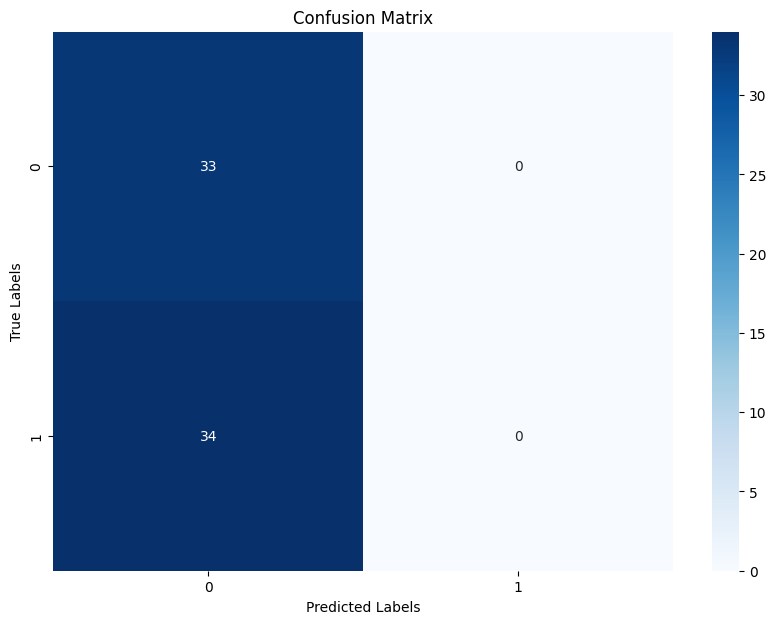

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the rest of your imports and model setup is already done

model = eegLSTM().to(device)
model.load_state_dict(torch.load('/Users/aarooshbalakrishnan/Desktop/EEGWORK/EEG_Projs/p300LTSM.pth.tar'))
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    total = 0
    correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        predictions = model(X_test)
        _, predicted = torch.max(predictions.data, 1)  # returns max value, indices
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()  # .item() give the raw number

        # Collecting labels
        true_labels.extend(y_test.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
    
    acc = 100 * (correct / total)
    print(f"Accuracy: {acc:2.3f}")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
